<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Linear Regression for Time Series Data

_Authors: Kevin Markham (Washington, D.C.), Ed Podojil (New York City)_

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
plt.style.use('fivethirtyeight')

In [2]:
%matplotlib inline

In [3]:
bikes = pd.read_csv('../assets/data/bikeshare_modified.csv',
                    index_col='datetime',
                    parse_dates=True
                   )

## Hang on a Second...

There's something fishy about our model. We are trying to "predict" the number of riders at a given time from the values that other variables have *at that same time*. That's...not prediction.

Traditional time series modeling techniques that have been developed in statistics and econometrics would predict the value of `num_total_users` at a given time from values of that same variable at previous times. In this notebook, we will instead adapt linear regression to predict `num_total_users` from other variables.

This general approach of applying standard supervised learning models to time-series data often gives better results than traditional time series modeling in machine learning competitions.

## Using a Standard Supervised Learning Model with Time-Series Data

### Time-Shifting the Feature Variables

If we want to be able to predict ridership two hours in advance, for instance, then we need to do it using only information that is available two hours in advance.

One way to do that is to take the variables that we cannot know in advance and to shift them back in time. For instance, at 6pm we cannot use the temperature at 8pm to predict ridership at 8pm, but we can use the temperature at 6pm, which is after all strongly correlated with the temperature at 6pm.

In [4]:
# Shift variables that cannot be known in advance forward in time
# /scrub/
time_sensitive_features = ['weather',
                           'temp_celsius',
                           'atemp_celsius',
                           'humidity_percent',
                           'windspeed_knots'
                          ]
for feature in time_sensitive_features:
    new_feature = feature + '_2hrs_ago'
    bikes.loc[:, new_feature] = bikes.loc[:, feature].shift(2)

In [5]:
bikes.head()

,season_num,is_holiday,is_workingday,weather,temp_celsius,atemp_celsius,humidity_percent,windspeed_knots,num_casual_users,num_registered_users,num_total_users,weather_2hrs_ago,temp_celsius_2hrs_ago,atemp_celsius_2hrs_ago,humidity_percent_2hrs_ago,windspeed_knots_2hrs_ago
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,3.28,3.0014,81,0.0,3,13,16,NaN,NaN,NaN,NaN,NaN
2011-01-01 01:00:00,1,0,0,1,2.34,1.9982,80,0.0,8,32,40,NaN,NaN,NaN,NaN,NaN
2011-01-01 02:00:00,1,0,0,1,2.34,1.9982,80,0.0,5,27,32,1.0,3.28,3.0014,81.0,0.0
2011-01-01 03:00:00,1,0,0,1,3.28,3.0014,75,0.0,3,10,13,1.0,2.34,1.9982,80.0,0.0
2011-01-01 04:00:00,1,0,0,1,3.28,3.0014,75,0.0,0,1,1,1.0,2.34,1.9982,80.0,0.0


In [6]:
# Delete the rows for which we do not have shifted weather information
# /scrub/
bikes = bikes.iloc[2:, :]

### Taking the Test Set from the End

We should also take the test set from the *end* of the time period covered by the data, because in practice when we deploy the model it will run on data that comes from later in time than the data it was trained on.

Let's see how our model does with these modifications.

In [7]:
# 1. Split your feature columns from your target column
# /scrub/
target_col = 'num_total_users'
X = bikes.drop(target_col, axis='columns')
y = bikes.loc[:, target_col]

In [8]:
# 2. Refine your feature columns.
# /scrub/
feature_cols = [feature + '_2hrs_ago' for feature in time_sensitive_features]
X = X.loc[:, feature_cols]

The cell above uses the handy "list comprehension" to build up a list inside a for-loop. It is equivalent to the following more verbose code:

```python
feature_cols = []
for var in time_sensitive_features:
    feature_cols.append(var)
```

In [9]:
# 3. Split your rows into a training set and a test set.
# /scrub/
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=16)

In [10]:
# Confirm that the split worked as expected
# /scrub/
print(X_train.index)
print(X_test.index)

DatetimeIndex(['2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               '2011-01-01 10:00:00', '2011-01-01 11:00:00',
               ...
               '2012-07-01 21:00:00', '2012-07-01 22:00:00',
               '2012-07-01 23:00:00', '2012-07-02 00:00:00',
               '2012-07-02 01:00:00', '2012-07-02 02:00:00',
               '2012-07-02 03:00:00', '2012-07-02 04:00:00',
               '2012-07-02 05:00:00', '2012-07-02 06:00:00'],
              dtype='datetime64[ns]', name='datetime', length=13032, freq=None)
DatetimeIndex(['2012-07-02 07:00:00', '2012-07-02 08:00:00',
               '2012-07-02 09:00:00', '2012-07-02 10:00:00',
               '2012-07-02 11:00:00', '2012-07-02 12:00:00',
               '2012-07-02 13:00:00', '2012-07-02 14:00:00',
               '2012-07-02 15:00:00', '2012-07

In [11]:
# 1. Import the LinearRegression class.
# /scrub/
from sklearn.linear_model import LinearRegression

In [12]:
# 2. Make an instance of the LinearRegression class.
# /scrub/
lr_ts = LinearRegression()
type(lr_ts)

sklearn.linear_model.base.LinearRegression

In [13]:
# 3. Train the model instance on the training set.
# /scrub/
lr_ts.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [14]:
# 4. Score the model on the test set.
# /scrub/
from sklearn.metrics import mean_squared_error

predictions = lr_ts.predict(X_test)
np.sqrt(mean_squared_error(y_test, predictions))

212.64445129141262

Rats -- our model is a lot worse when we use it for actual prediction.

### Incorporating Time-Based Features

Ridership depends heavily on time of day and day of week:

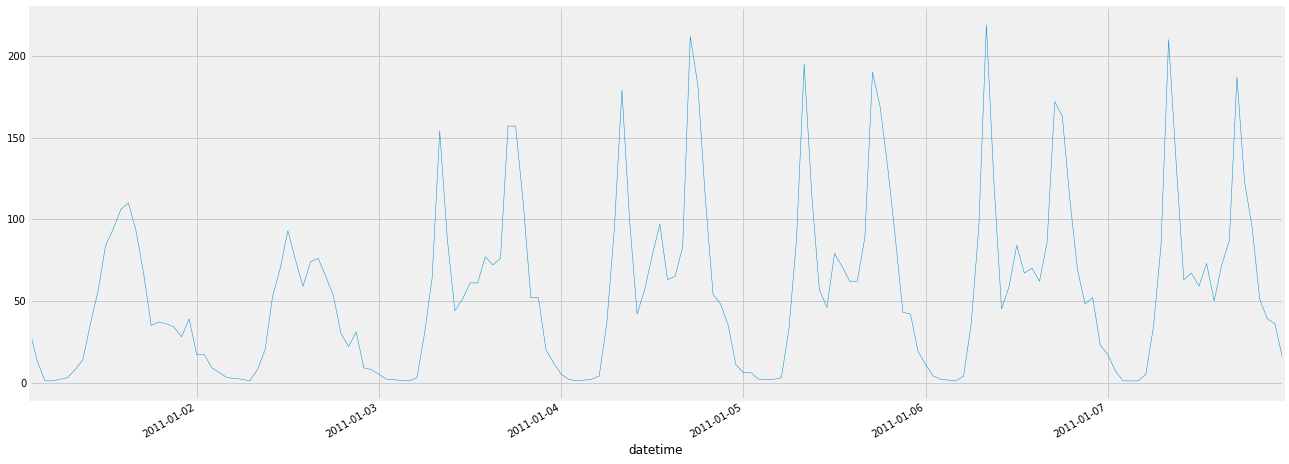

In [15]:
# Plot ridership vs. time for the first week of data
# /scrub/
ax = bikes.loc[:'2011-01-07', 'num_total_users'].plot(figsize=(20, 8), linewidth=.5);

It also depends on the month of the year and on time since the start of the program:

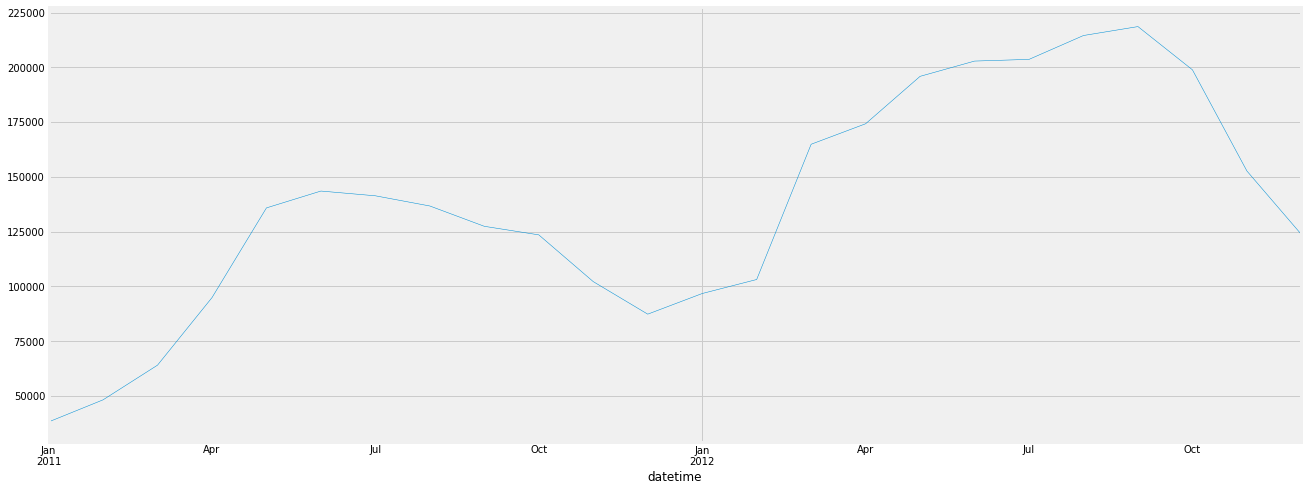

In [16]:
# Plot total monthly ridership vs. time
bikes.loc[:, 'num_total_users'].resample('M').sum().plot(figsize=(20, 8), linewidth=.5);

Why not create features for these variables?

In [17]:
# Create a feature for hour of day
# /scrub/
bikes.loc[:, 'hour_of_day'] = bikes.index.hour

We already have an "is_workingday" variable that should capture the "day of week" effect to some extent.

In [18]:
# Create a feature for hours from start of dataset
# /scrub/
bikes.loc[:, 'hours_from_start'] = range(len(bikes))

In [19]:
# Create a feature for month of year
# /scrub/
bikes.loc[:, 'month'] = bikes.index.month

In [20]:
# Dummy-code hour of day and month of year
# /scrub/
bikes = pd.get_dummies(bikes, columns=['hour_of_day', 'month'], drop_first=True)

In [21]:
bikes.head()

,season_num,is_holiday,is_workingday,weather,temp_celsius,atemp_celsius,humidity_percent,windspeed_knots,num_casual_users,num_registered_users,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 02:00:00,1,0,0,1,2.34,1.9982,80,0.0000,5,27,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 03:00:00,1,0,0,1,3.28,3.0014,75,0.0000,3,10,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 04:00:00,1,0,0,1,3.28,3.0014,75,0.0000,0,1,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 05:00:00,1,0,0,2,3.28,1.0016,75,0.0896,0,1,...,0,0,0,0,0,0,0,0,0,0
2011-01-01 06:00:00,1,0,0,1,2.34,1.9982,80,0.0000,2,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# 1. Split your feature columns from your target column
# We still have `y` from before.
# /scrub/
X = bikes.drop(target_col, axis='columns')

In [23]:
# Create list of feature variable names
# /scrub/
time_cols = [col for col in bikes.columns if col.startswith(('hour', 'month'))] + ['is_workingday']
feature_cols += time_cols
feature_cols

['weather_2hrs_ago',
 'temp_celsius_2hrs_ago',
 'atemp_celsius_2hrs_ago',
 'humidity_percent_2hrs_ago',
 'windspeed_knots_2hrs_ago',
 'hours_from_start',
 'hour_of_day_1',
 'hour_of_day_2',
 'hour_of_day_3',
 'hour_of_day_4',
 'hour_of_day_5',
 'hour_of_day_6',
 'hour_of_day_7',
 'hour_of_day_8',
 'hour_of_day_9',
 'hour_of_day_10',
 'hour_of_day_11',
 'hour_of_day_12',
 'hour_of_day_13',
 'hour_of_day_14',
 'hour_of_day_15',
 'hour_of_day_16',
 'hour_of_day_17',
 'hour_of_day_18',
 'hour_of_day_19',
 'hour_of_day_20',
 'hour_of_day_21',
 'hour_of_day_22',
 'hour_of_day_23',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'is_workingday']

In [24]:
# 2. Refine your feature columns.
# /scrub/
X = X.loc[:, feature_cols]

The cell above uses the handy "list comprehension" to build up a list inside a for-loop. It is equivalent to the following more verbose code:

```python
feature_cols = []
for var in time_sensitive_features:
    feature_cols.append(var)
```

In [25]:
# 3. Split your rows into a training set and a test set.
# /scrub/
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=16)

In [26]:
# 2. Make an instance of the LinearRegression class.
# /scrub/
lr_ts = LinearRegression()
type(lr_ts)

sklearn.linear_model.base.LinearRegression

In [27]:
# 3. Train the model instance on the training set.
# /scrub/
lr_ts.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [28]:
# 4. Score the model on the test set.
# /scrub/
predictions = lr_ts.predict(X_test)
np.sqrt(mean_squared_error(y_test, predictions))

137.44996882981954

$\blacksquare$

## Summary

- We can use standard supervised learning techniques to predict the values of one variable in a multivariate time series from the values of other variables in that time series, but not before those values are available. One way to address this problem is to shift the feature variables whose values cannot be known in advance forward in time relative to the target variable.
- With time series data we should also make sure that all of the training data comes from earlier in time than all of the test data.
- Using various aspects of time itself as features (e.g. hour of day, day of week, month of year) can be very powerful for data sets that show strong temporal patterns (called "seasonality").